# Defining custom surface types

Visisipy supports the optical surface types that are most commonly used in optical simulations.
For more advanced simulations, it is possible to define a custom surface type.
This guide demonstrates how to implement Optiland's toroidal surface type.
A similar approach can be used to implement custom surfaces for the OpticStudio backend.

## Generic surface definition

First, we create a `ToroidalSurface` class that inherits from `StandardSurface`.
This class is not backend-specific; it is used to provide a common interface for all supported backends, and can be used when creating the eye model.
For surfaces available in Visisipy, similar classes are defined in {py:mod}`visisipy.models.geometry`.
To simplify the class definition, we use a `dataclass`.

In [1]:
from __future__ import annotations

In [2]:
from dataclasses import dataclass, field

from visisipy.models.geometry import StandardSurface


@dataclass
class ToroidalSurface(StandardSurface):
    """Toroidal surface definition.

    Attributes
    ----------
    radius : float
        The radius of the surface in the y (inferior-superior) direction. Default is infinity.
    asphericity : float
        The asphericity of the surface in the y (inferior-superior) direction. Default is 0.
    thickness : float
        The thickness of the surface. Default is 0.
    semi_diameter : float | None
        The semi-diameter of the surface aperture. Default is `None`.
    is_stop : bool
        If `True`, the surface is a stop surface. Default is `False`.
    rotation_radius : float
        Radius of rotation in the XZ plane.
    coeffs_poly_y : list[float]
        Polynomial coefficients in the YZ plane. This curve is rotated around an axis parallel to the y axis.
    """

    rotation_radius: float = float("inf")
    coeffs_poly_y: list[float] = field(default_factory=list)

## Backend-specific implementation

We can now write a backend-specific implementation of the `ToroidalSurface` class.
This class implements the logic used to build the surface in the Optiland backend.

The implementation shown below is a minimal example that only supports creating the surface.
The implementations in {py:mod}`visisipy.models.geometry`, also provide methods to access the surface parameters, and use more robust type hints.

In [3]:
from typing import TYPE_CHECKING

from visisipy.models.materials import MaterialModel  # noqa: TC001
from visisipy.optiland.surfaces import BaseOptilandSurface

if TYPE_CHECKING:
    from optiland.optic import Optic


class OptilandToroidalSurface(BaseOptilandSurface):
    """Toroidal surface in Optiland."""

    # Name of the geometry type in Optiland
    _TYPE: str = "toroidal"

    def __init__(
        self,
        comment: str,
        *,
        radius: float = float("inf"),
        radius_x: float = float("inf"),
        thickness: float = 0.0,
        semi_diameter: float | None = None,
        conic: float = 0.0,
        toroidal_coeffs_poly_y: list[float] | None = None,
        material: MaterialModel | str | None = None,
        is_stop: bool | None = None,
    ):
        super().__init__()

        self._comment = comment
        self._radius = radius
        self._radius_x = radius_x
        self._thickness = thickness
        self._semi_diameter = semi_diameter
        self._conic = conic
        self._coeffs_poly_y = toroidal_coeffs_poly_y if toroidal_coeffs_poly_y is not None else []
        self._material = material
        self._is_stop = is_stop

    def build(self, optic: Optic, *, position: int, replace_existing: bool = False) -> int:
        """Create the surface in Optiland.

        Create the surface in the provided `Optic` object at the specified `position`.
        By default, a new surface will be created. If `replace_existing` is `True`, the existing surface at the
        specified position will be replaced.

        Parameters
        ----------
        optic : Optic
            The Optic object to which the surface will be added.
        position : int
            The index at which the surface will be added, starting at 0 for the object surface.
        replace_existing : bool
            If `True`, replace an existing surface instead of inserting a new one. Defaults to `False`.

        Returns
        -------
        int
            The index of the created surface. Subsequent surfaces should be after this index.
        """
        self._create_surface(
            optic=optic,
            position=position,
            replace_existing=replace_existing,
            comment=self._comment,
            # Optiland uses radius_x for the rotation radius
            radius=self._radius_x,
            # Optiland uses radius_y for the radius of curvature
            radius_y=self._radius,
            thickness=self._thickness,
            semi_diameter=self._semi_diameter,
            conic=self._conic,
            toroidal_coeffs_poly_y=self._coeffs_poly_y,
            material=self._convert_material(self._material),
            is_stop=bool(self._is_stop),
        )

        # Note that the build method must return the position of the created surface.
        # This is used to determine where subsequent surfaces should be added
        return position

## Surface factory function

When building the eye model, the `ToroidalSurface` object needs to be converted to an `OptilandToroidalSurface` object.
This is done using the {py:func}`make_surface <visisipy.optiland.surfaces.make_surface>` factory function, which is defined for each backend separately.
The factory function has the following signature:

```python
def make_surface(surface: Surface, material: str | MaterialModel, comment: str = "") -> OptilandSurface: ...
```

Using [single dispatch](https://docs.python.org/3/library/functools.html#functools.singledispatch),
multiple implementations of the `make_surface` function can be defined for different surface types.
Which implementation is used depends on the type of the `surface` argument.
A new implementation can be registered using the `@make_surface.register` decorator, as shown below.


In [4]:
from typing import Union

from visisipy.optiland.surfaces import make_surface


@make_surface.register
def _make_toroidal_surface(
    surface: ToroidalSurface,
    material: Union[str, MaterialModel],  # noqa: UP007
    comment: str = "",
) -> OptilandToroidalSurface:
    return OptilandToroidalSurface(
        comment=comment,
        radius=surface.radius,
        radius_x=surface.rotation_radius,
        thickness=surface.thickness,
        semi_diameter=surface.semi_diameter,
        conic=surface.asphericity,
        toroidal_coeffs_poly_y=surface.coeffs_poly_y,
        material=material,
    )

## Testing the implementation

Let's see if we can create a toroidal surface using the factory function:

In [ ]:
test_toroidal_surface = make_surface(
    ToroidalSurface(rotation_radius=2), material="BK7", comment="Toroidal surface example"
)

print(test_toroidal_surface._radius_x == 2)  # noqa: PLR2004, SLF001

True


We can now create an eye model with a toroidal cornea.

In [6]:
import visisipy

visisipy.set_backend("optiland")

example_model = visisipy.EyeModel(
    geometry=visisipy.NavarroGeometry(
        cornea_front=ToroidalSurface(
            radius=7.72, asphericity=-0.26, thickness=0.55, rotation_radius=5, coeffs_poly_y=[0.0, 0.0]
        )
    )
)

example_model.build()

To check if the surface was created correctly, we can inspect the `Optic` object in the Optiland backend.
Let's print the system information and draw the eye model!

╒════╤═══════════════╤═══════════════════════╤══════════╤═════════════╤═══════════════╤═════════╤═════════════════╕
│    │ Type          │ Comment               │   Radius │   Thickness │ Material      │   Conic │   Semi-aperture │
╞════╪═══════════════╪═══════════════════════╪══════════╪═════════════╪═══════════════╪═════════╪═════════════════╡
│  0 │ Planar        │                       │    inf   │    inf      │ Air           │  0      │        1.66242  │
│  1 │ Toroidal      │ cornea front          │      5   │      0.55   │ 1.3761, 53.05 │  0      │        1.66242  │
│  2 │ Standard      │ cornea back / aqueous │      6.5 │      3.05   │ 1.3375, 48.50 │  0      │        1.61228  │
│  3 │ Stop - Planar │ pupil                 │    inf   │      0      │ 1.3375, 48.50 │  0      │        1.348    │
│  4 │ Standard      │ lens front            │     10.2 │      4      │ 1.4201, 46.38 │ -3.1316 │        1.348    │
│  5 │ Standard      │ lens back / vitreous  │     -6   │     16.3203 │ 

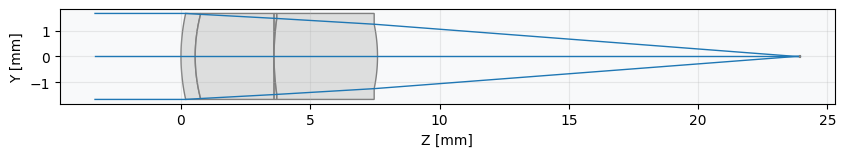

In [7]:
optic = visisipy.get_optic()

optic.info()
optic.draw()

As shown above, the `Optic` object contains the toroidal surface with the correct parameters.
For more information about the surface, we can inspect the `geometry` attribute of the surface object.

In [8]:
# Show the full geometry of the toroidal surface

optic.surface_group.surfaces[1].geometry.to_dict()

{'type': 'ToroidalGeometry',
 'cs': {'x': 0.0,
  'y': 0.0,
  'z': 0.0,
  'rx': 0.0,
  'ry': 0.0,
  'rz': 0.0,
  'reference_cs': None},
 'tol': 1e-06,
 'max_iter': 100,
 'geometry_type': 'Toroidal',
 'radius_rotation': array(5.),
 'radius_yz': array(7.72),
 'conic_yz': array(-0.26),
 'coeffs_poly_y': [0.0, 0.0]}

## Contributing custom surfaces

If you developed a custom surface type, please consider [contributing](../contributing.md) it to Visisipy.
For more details on the full implementation of new surface types, we recommend checking the source code of the existing surfaces in {py:mod}`visisipy.models.geometry`, {py:mod}`visisipy.optiland.surfaces`, and {py:mod}`visisipy.opticstudio.surfaces`.
